# Visualize the cumulative R2 of mobility networks

- TBD: Why is the cumulative R2 way better than the LASSO results?! The LASSO performance is worth further exploration.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import copy
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression

# regression tools
import statsmodels.api as sm
from sklearn.preprocessing import normalize


Bad key text.latex.unicode in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')


In [2]:
# locations
fig_location = '../../../economic-strength-of-weak-mobility-ties-paper-/figs/'


In [3]:
# 
with open('../../data/05_model_outputs/performance_cumulative_mobility_networks.pickle', 'rb') as f:
    cum_r2_dic = pickle.load(f)
    
cum_r2_dic


{'boston': {'inc_median_household_2018': [0.14211897891010428,
   0.257154695169051,
   0.3503440606828798,
   0.3848676906949061,
   0.4181052930021547,
   0.43145946089114684,
   0.44237610036055386,
   0.45178515925614837,
   0.4632689046217142,
   0.4658832829644375,
   0.4735215832182694,
   0.48243496292415144,
   0.4925380188316869,
   0.4987029368003777,
   0.5035599415992749],
  'property_value_median_2018': [0.2580737197645969,
   0.32214736715826475,
   0.34181020824162633,
   0.4619978649705223,
   0.4835786008141826,
   0.49326140022362264,
   0.49842493458113935,
   0.5169637386674317,
   0.5195331711464424,
   0.5308909453522215,
   0.5328029118428035,
   0.5426243559861801,
   0.5467738753923446,
   0.5499253285880943,
   0.5523169018132092],
  'rent_median_2018': [0.11922834532498705,
   0.15203524449305394,
   0.16440286776656055,
   0.1695890034853429,
   0.17997309627659286,
   0.19307851718035307,
   0.20767370342770175,
   0.2263052560706158,
   0.2457539458445852

In [4]:
with open('../../data/05_model_outputs/lasso_performance.pickle', 'rb') as f:
    performance_dic = pickle.load(f)
    
with open('../../data/05_model_outputs/lasso_coefficients.pickle', 'rb') as f:
    coeff_dic = pickle.load(f)

In [6]:
# read files
with open("../../data/02_intermediate/boston_stays.pickle", 'rb') as f:
    df_boston = pickle.load(f)

with open("../../data/02_intermediate/miami_stays.pickle", 'rb') as f:
    df_miami = pickle.load(f)

with open("../../data/02_intermediate/chicago_stays.pickle", 'rb') as f:
    df_chicago = pickle.load(f)


In [7]:
# sort the coefficient dictionary
output_list = ['inc_median_household_2018', 'property_value_median_2018', 'rent_median_2018']
city_list = ['boston', 'chicago', 'miami']
coeff_df_dic = {}

for city in city_list:
    coeff_df_dic[city] = {}
    for output_idx in np.arange(3):
    #     print(output_idx)    
        output = output_list[output_idx]

        ### create the cummulative shares of mobility network counts
        coeff_df_ = coeff_dic[city][output]['lasso (no socio-demographics)']

        # sort according to abs values.
        coeff_df_.value = np.abs(coeff_df_.value)
        coeff_df_ = coeff_df_.sort_values('value', ascending = False)
        
        coeff_df_dic[city][output] = coeff_df_
        
coeff_df_dic

{'boston': {'inc_median_household_2018':                    value
  French          0.077346
  Skating Rink    0.062328
  Latin American  0.052719
  Caribbean       0.047442
  Cupcakes        0.042785
  Peking Duck     0.039055
  Brazilian       0.033213
  Ski Area        0.028614
  Science Museum  0.027285
  Fried Chicken   0.026100
  Football        0.024686
  Fishing Store   0.024188
  Tennis Court    0.022838
  Food Stand      0.022041
  Laundromat      0.020124,
  'property_value_median_2018':                       value
  French             0.098779
  Salad              0.083690
  Cycle Studio       0.071260
  Discount Store     0.045884
  Convenience Store  0.042458
  Hot Dogs           0.032983
  Car Washes         0.029239
  Bagels             0.028036
  Latin American     0.026444
  Locksmith          0.025664
  Tattoo             0.024189
  Art Museum         0.023082
  Brazilian          0.022922
  Video Games        0.021531
  Strip Club         0.021167,
  'rent_median_20

In [8]:
# boston
activity_counts_boston = np.unique(df_boston.cat, return_counts = True)

# miami
activity_counts_miami = np.unique(df_miami.cat, return_counts = True)

# chicago
activity_counts_chicago = np.unique(df_chicago.cat, return_counts = True)

In [9]:
# convert the counts to df
activity_counts_dic = {}
activity_counts_dic['boston']=activity_counts_boston
activity_counts_dic['miami']=activity_counts_miami
activity_counts_dic['chicago']=activity_counts_chicago
# activity_counts_dic['nyc']=activity_counts_nyc

# turn them to dataframes
activity_counts_df_dic = {}
for key_ in activity_counts_dic.keys():
    activity_counts = activity_counts_dic[key_]
    activity_count_df = pd.DataFrame(activity_counts[1],
                                 index = activity_counts[0],
                                 columns = ['count'])
    sorted_activity_count_df = activity_count_df.sort_values('count', ascending=False)
    activity_counts_df_dic[key_] = sorted_activity_count_df


In [10]:
# Create the cumulative counts for 3*3 cases.
x_list = np.arange(15)
cum_counts_dic = {}

for city in city_list:
    cum_counts_dic[city] = {}
    for output in output_list:
        y_list = [] 
        cum_counts = 0.0
        for idx in x_list:
            activity_name = coeff_df_dic[city][output].index[idx]
            activity_count = activity_counts_df_dic[city].loc[activity_name, 'count']
            cum_counts += activity_count
            y_list.append(cum_counts/activity_counts_df_dic[city].sum()[0])
        cum_counts_dic[city][output] = np.array(y_list)
            

In [11]:
cum_counts_dic

{'boston': {'inc_median_household_2018': array([0.00039904, 0.00263593, 0.00323632, 0.00436543, 0.00462924,
         0.00464559, 0.00545504, 0.00579535, 0.00614171, 0.00653312,
         0.00742853, 0.00745541, 0.00840183, 0.0084219 , 0.0089921 ]),
  'property_value_median_2018': array([0.00039904, 0.00088196, 0.00127171, 0.00342987, 0.01387155,
         0.0143037 , 0.01658008, 0.01738115, 0.01798154, 0.01813527,
         0.01913578, 0.01965305, 0.0204625 , 0.02113789, 0.02258175]),
  'rent_median_2018': array([0.00039904, 0.00091631, 0.00212987, 0.00284416, 0.00303979,
         0.0040997 , 0.00538643, 0.00613474, 0.00726385, 0.00761345,
         0.00804559, 0.00854867, 0.00876454, 0.01062171, 0.01063747])},
 'chicago': {'inc_median_household_2018': array([0.00211477, 0.00536821, 0.0056651 , 0.0058775 , 0.00648076,
         0.00690812, 0.00729552, 0.00811727, 0.00816883, 0.0082596 ,
         0.00842943, 0.008435  , 0.00843778, 0.00865686, 0.00880056]),
  'property_value_median_2018': ar

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


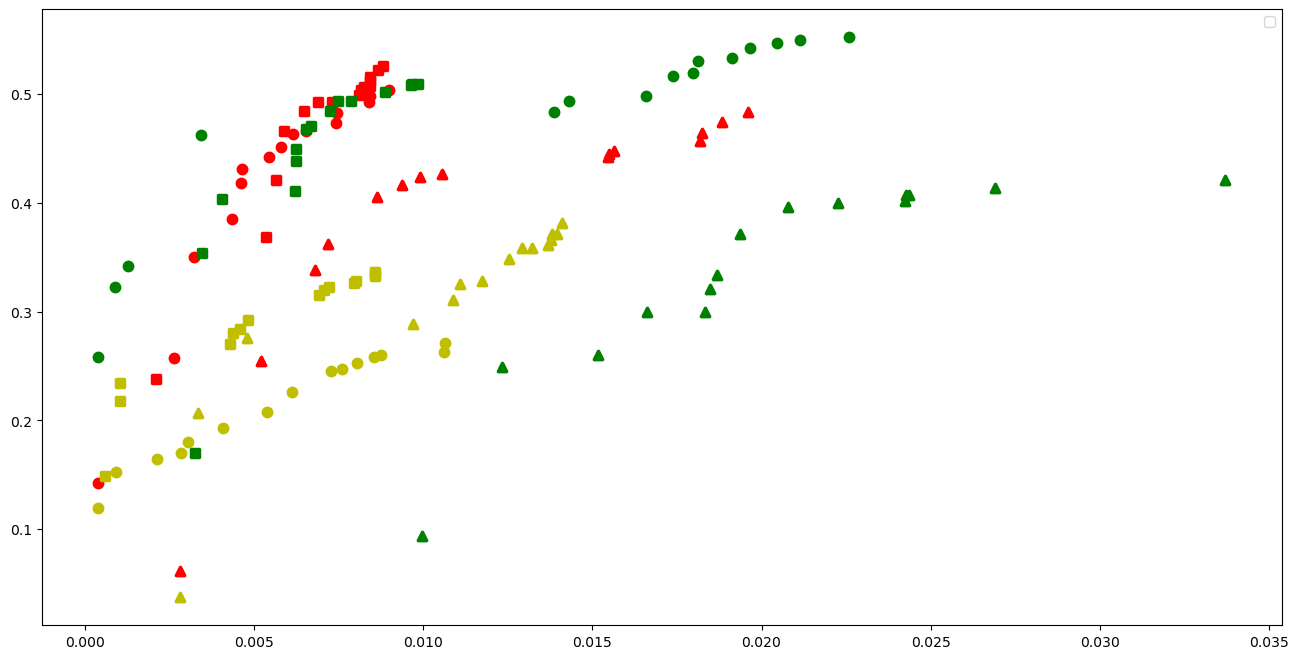

In [44]:
# fig, ax = plt.subplots(figsize = (16,8))
# color_list = ['r', 'g', 'y']
# marker_list = ['o', 's', '^']

# for city_idx in np.arange(3):
#     city = city_list[city_idx]    
#     for output_idx in np.arange(3):
#         output = output_list[output_idx]
        
#         ax.scatter(cum_counts_dic[city][output], cum_r2_dic[city][output], marker=marker_list[city_idx], 
#                    linewidth = 2.5, alpha = 1.0, color = color_list[output_idx])
        
# ax.legend()
# plt.show()

In [12]:
# print the results. 
output_list = ['inc_median_household_2018', 'property_value_median_2018', 'rent_median_2018']
city_list = ['boston', 'chicago', 'miami']

for city in city_list:
    for output in output_list:
        print(city, output)
        print(max(cum_r2_dic[city][output]))
        print()


boston inc_median_household_2018
0.5035599415992749

boston property_value_median_2018
0.5523169018132092

boston rent_median_2018
0.2709502546682665

chicago inc_median_household_2018
0.5262413223074811

chicago property_value_median_2018
0.5097138940776361

chicago rent_median_2018
0.33620462361557535

miami inc_median_household_2018
0.48365974674920464

miami property_value_median_2018
0.42072673096639335

miami rent_median_2018
0.3816055466714474



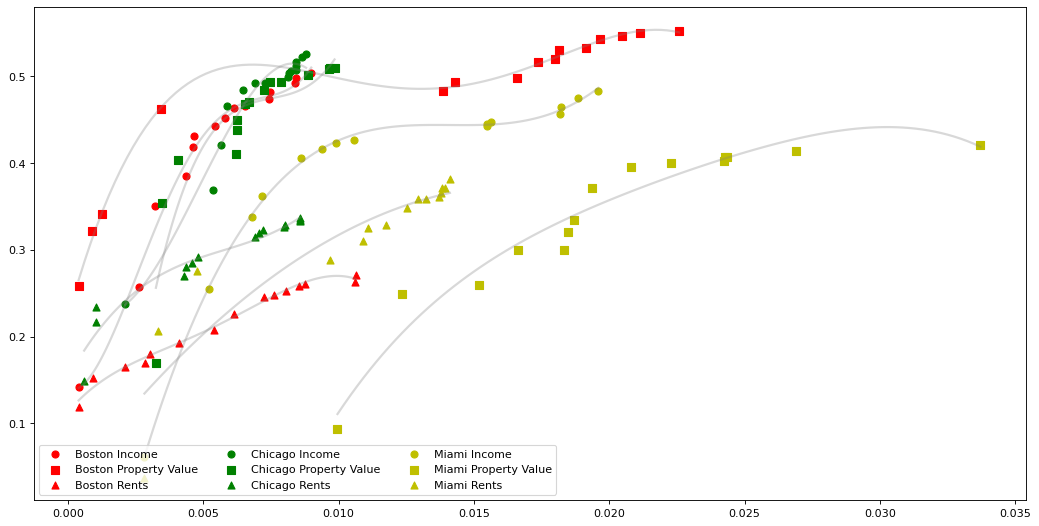

In [13]:
# Create the nine scatters 
color_list = ['r', 'g', 'y']
marker_list = ['o', 's', '^']
line_type = ['--', '-.']
line_alpha = 0.3
linewidth = 2
point_size = 40
fit_degree = 4

plt.figure(figsize=(16, 8), dpi=80)

# line 1
city = 'boston'; output = 'inc_median_household_2018'
bi = plt.scatter(cum_counts_dic[city][output], cum_r2_dic[city][output], 
                 color = 'r', marker = 'o', s = point_size)
fittedParameters = np.polyfit(cum_counts_dic[city][output], cum_r2_dic[city][output], deg = fit_degree)
y_pred = np.polyval(fittedParameters, np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100))
bi_line = plt.plot(np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100), y_pred, linewidth = linewidth, alpha = line_alpha, color = 'grey')

# line 2
city = 'boston'; output = 'property_value_median_2018'
bp = plt.scatter(cum_counts_dic[city][output], cum_r2_dic[city][output], 
                 color = 'r', marker = 's', s = point_size)
fittedParameters = np.polyfit(cum_counts_dic[city][output], cum_r2_dic[city][output], deg = fit_degree)
y_pred = np.polyval(fittedParameters, np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100))
bp_line = plt.plot(np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100), y_pred, linewidth = linewidth, alpha = line_alpha, color = 'grey')

# line 3
city = 'boston'; output = 'rent_median_2018'
br = plt.scatter(cum_counts_dic[city][output], cum_r2_dic[city][output], 
                 color = 'r', marker = '^', s = point_size)
fittedParameters = np.polyfit(cum_counts_dic[city][output], cum_r2_dic[city][output], deg = fit_degree)
y_pred = np.polyval(fittedParameters, np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100))
br_line = plt.plot(np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100), y_pred, linewidth = linewidth, alpha = line_alpha, color = 'grey')

### 
# line 1
city = 'chicago'; output = 'inc_median_household_2018'
ci = plt.scatter(cum_counts_dic[city][output], cum_r2_dic[city][output], 
                 color = 'g', marker = 'o', s = point_size)
fittedParameters = np.polyfit(cum_counts_dic[city][output], cum_r2_dic[city][output], deg = 3)
y_pred = np.polyval(fittedParameters, np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100))
ci_line = plt.plot(np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100), y_pred, linewidth = linewidth, alpha = line_alpha, color = 'grey')

# line 2
city = 'chicago'; output = 'property_value_median_2018'
cp = plt.scatter(cum_counts_dic[city][output], cum_r2_dic[city][output], 
                 color = 'g', marker = 's', s = point_size)
fittedParameters = np.polyfit(cum_counts_dic[city][output], cum_r2_dic[city][output], deg = 3)
y_pred = np.polyval(fittedParameters, np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100))
cp_line = plt.plot(np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100), y_pred, linewidth = linewidth, alpha = line_alpha, color = 'grey')

# line 3
city = 'chicago'; output = 'rent_median_2018'
cr = plt.scatter(cum_counts_dic[city][output], cum_r2_dic[city][output], 
                 color = 'g', marker = '^', s = point_size)
fittedParameters = np.polyfit(cum_counts_dic[city][output], cum_r2_dic[city][output], deg = 3)
y_pred = np.polyval(fittedParameters, np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100))
cr_line = plt.plot(np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100), y_pred, linewidth = linewidth, alpha = line_alpha, color = 'grey')

### 
# line 1
city = 'miami'; output = 'inc_median_household_2018'
mi = plt.scatter(cum_counts_dic[city][output], cum_r2_dic[city][output], 
                 color = 'y', marker = 'o', s = point_size)
fittedParameters = np.polyfit(cum_counts_dic[city][output], cum_r2_dic[city][output], deg = 3)
y_pred = np.polyval(fittedParameters, np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100))
mi_line = plt.plot(np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100), y_pred, linewidth = linewidth, alpha = line_alpha, color = 'grey')

# line 2
city = 'miami'; output = 'property_value_median_2018'
mp = plt.scatter(cum_counts_dic[city][output], cum_r2_dic[city][output], 
                 color = 'y', marker = 's', s = point_size)
fittedParameters = np.polyfit(cum_counts_dic[city][output], cum_r2_dic[city][output], deg = fit_degree)
y_pred = np.polyval(fittedParameters, np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100))
mp_line = plt.plot(np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100), y_pred, linewidth = linewidth, alpha = line_alpha, color = 'grey')

# line 3
city = 'miami'; output = 'rent_median_2018'
mr = plt.scatter(cum_counts_dic[city][output], cum_r2_dic[city][output], 
                 color = 'y', marker = '^', s = point_size)
fittedParameters = np.polyfit(cum_counts_dic[city][output], cum_r2_dic[city][output], deg = 2)
y_pred = np.polyval(fittedParameters, np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100))
mr_line = plt.plot(np.linspace(min(cum_counts_dic[city][output]), max(cum_counts_dic[city][output]), 100), y_pred, linewidth = linewidth, alpha = line_alpha, color = 'grey')

plt.legend((bi, bp, br, ci, cp, cr, mi, mp, mr), 
           ('Boston Income','Boston Property Value', 'Boston Rents', 'Chicago Income','Chicago Property Value', 'Chicago Rents', 'Miami Income','Miami Property Value', 'Miami Rents'), 
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=10)

params = {
     'legend.fontsize': 20,
     'axes.labelsize': 20,
     'axes.titlesize': 30,
     'xtick.labelsize': 15,
     'ytick.labelsize': 15}
plt.rcParams.update(params)

# plt.xlabel("Cumulative share of mobility ties")
# plt.ylabel("Cumulative R square")

plt.show()


In [14]:
fittedParameters

array([-1.21311615e+03,  4.10524759e+01,  2.79064922e-02])